In [68]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

In [69]:
start = pd.to_datetime('2010-08-02')
end = pd.to_datetime('2018-08-02')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
data.reset_index(inplace = True)
data = data[['Open', 'High','Low', 'Close', 'Volume']]
print(data.head())


y = pd.DataFrame()

for i in range(len(data) - 1):
    if data.loc[i + 1, 'Open'] - data.loc[i, 'Close'] > 0:
        y.loc[i, 0] = 1
    else:
        y.loc[i, 0] = 0

print(y)      

print(len(data))
data_train = data.iloc[0:1601,] 
data_test = data.iloc[1601:2001,]
print(len(data_train))
print(len(data_test))

y_train = y.iloc[0:1601,] 
y_test = y.iloc[1601:2001,]

[*********************100%***********************]  1 of 1 completed
        Open       High        Low      Close     Volume
0  12.179100  12.285949  12.128041  12.214467   74626675
1  12.216709  12.265526  12.123558  12.200021   72362219
2  12.258552  12.627668  12.230407  12.610732  153071607
3  12.600022  12.667519  12.541990  12.655066   97178890
4  12.587818  12.596286  12.354941  12.458801  133277692
        0
0     1.0
1     1.0
2     0.0
3     0.0
4     1.0
...   ...
2009  0.0
2010  1.0
2011  0.0
2012  1.0
2013  1.0

[2014 rows x 1 columns]
2015
1601
400


<Axes: >

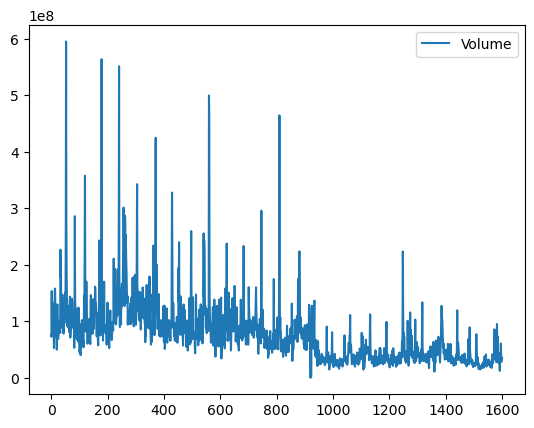

In [70]:
seaborn.lineplot(data_train.loc[:,["Volume"]]) #plot the value of close

In [71]:
def preprocess_exp(data):
    # use the estimates to calculate the curve
    preprocessed = pd.DataFrame()
    PF = pd.DataFrame()
    
    for col in ['Open', 'High', 'Low', 'Close']:
        PF = np.polyfit(data.index, np.log(data.loc[:, col]), 1)
        # divide by trend
        str_col = col + 'NoExp'
        preprocessed[str_col] = data[col] / (np.exp(PF[0] * data.index + PF[1]))
        preprocessed[str_col] = (preprocessed[str_col] - np.mean(preprocessed[str_col]))/np.std(preprocessed[str_col])

    return preprocessed

      OpenNoExp  HighNoExp  LowNoExp  CloseNoExp
0      0.057101   0.062654  0.106108    0.090511
1      0.081199   0.037257  0.094319    0.070170
2      0.108856   0.337598  0.177912    0.413251
3      0.391200   0.363294  0.436622    0.442885
4      0.372652   0.294515  0.268435    0.267134
...         ...        ...       ...         ...
1596  -0.786425  -0.836654 -0.958066   -0.906673
1597  -0.955338  -0.917637 -0.888264   -0.881291
1598  -0.797588  -0.800303 -0.771435   -0.736749
1599  -0.716697  -0.745648 -0.722567   -0.787129
1600  -0.770841  -0.721238 -0.749338   -0.642134

[1601 rows x 4 columns]


<Axes: >

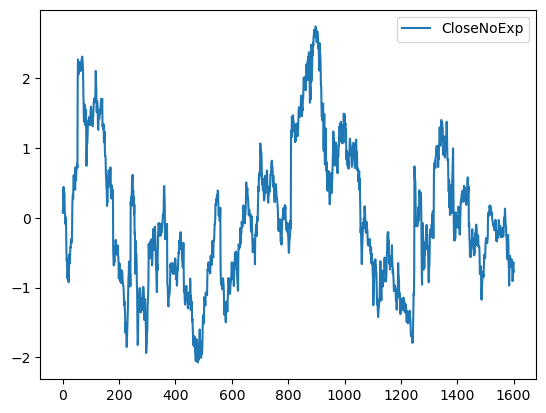

In [72]:
preprocessed = preprocess_exp(data_train)
print(preprocessed)
# plot the line with the trend removed
seaborn.lineplot(preprocessed[["CloseNoExp"]])

In [73]:
##Multivariate RNN
cutOff = 1300 
preprocessed = np.array(preprocess_exp(data_train))
print(preprocessed)

validation = preprocessed[cutOff:]
train = preprocessed[:cutOff]

size_train = len(train)
size_validation = len(validation)

x_train = np.reshape(train, (len(train), 1, 4))
y_train = y[:cutOff]

x_validation = np.reshape(validation, (len(validation), 1, 4))
y_validation = y[cutOff:cutOff + size_validation]

[[ 0.05710092  0.06265388  0.10610837  0.09051142]
 [ 0.08119878  0.03725682  0.09431895  0.07016994]
 [ 0.10885563  0.33759836  0.17791249  0.41325138]
 ...
 [-0.79758825 -0.80030276 -0.77143473 -0.73674949]
 [-0.71669653 -0.74564782 -0.72256692 -0.78712907]
 [-0.77084076 -0.72123823 -0.74933837 -0.64213364]]


In [74]:
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.SimpleRNN(120, input_shape = (x_train.shape[1], x_train.shape[2]), activation="relu"))
model.add(layers.Dense(1, activation = "relu"))

# model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                #    activation=['tanh', 'tanh'])
# model.fit(x_data, y_data, epochs=20, batch_size=1, verbose=2)

model.summary()

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=100, epochs= 20)

Model: "sequential_422"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 120)               15000     
                                                                 
 dense_422 (Dense)           (None, 1)                 121       
                                                                 
Total params: 15,121
Trainable params: 15,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3583 - accuracy: 0.4838
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.5331
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2774 - accuracy: 0.5323
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2657 - accuracy: 0.5346
Epoch 5/20
13/13 [==============================] - 

In [75]:
predictTrain = model.predict(x_train)
predictValidation = model.predict(x_validation)
print(len(x_train), len(x_validation))
print(len(data))

modelResults = pd.DataFrame()
modelResults["realValues"] = np.append(y_train, y_validation)
modelResults["estimatedValues"] = np.append(predictTrain, predictValidation)
for i in range(len(modelResults)):
    if modelResults.loc[i, "estimatedValues"] > 0.5:
        modelResults.loc[i, "estimatedValues"] = 1
    else:
        modelResults.loc[i, "estimatedValues"] = 0

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.array(modelResults["realValues"]), np.array(modelResults["estimatedValues"]))

accuracy = (cf[0][0]+cf[1][1])/len(modelResults)
print(accuracy)

10/10 [==============================] - 0s 804us/step
1300 301
2015
0.5484072454715803


<Axes: >

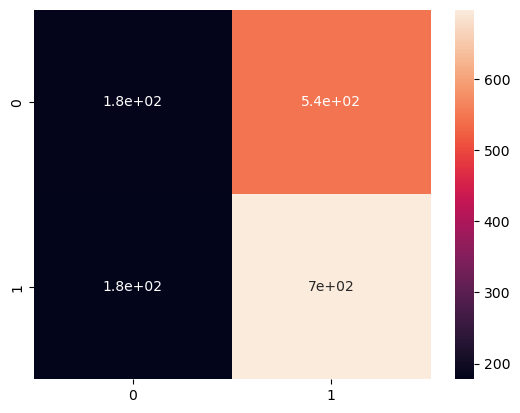

In [76]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.array(modelResults["realValues"]), np.array(modelResults["estimatedValues"]))
import seaborn as sns
sns.heatmap(cf, annot=True)

In [95]:
def create_LSTM_model(x_train, y_train, options):
    model = keras.Sequential()

    model.add(layers.LSTM(options[0][0], return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2]), activation=options[1]))

    if len(options[0]) > 1:
        if len(options[0]) > 2:
            for i in range(1,len(options[0])-1):
                model.add(layers.LSTM(options[0][i], return_sequences=True))
        model.add(layers.LSTM((options[0][-1])))
    
    model.add(layers.Dense(1, activation = "relu"))

    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=options[2], epochs= options[3], verbose=0)

    return model

def get_accuracy(model, x_validation, y_validation):
    predictValidation = model.predict(x_validation)

    modelResults = pd.DataFrame()
    modelResults["realValues"] = y_validation
    modelResults=modelResults.reset_index(drop=True)
    modelResults["estimatedValues"] = np.reshape(predictValidation, len(modelResults))
    

    for i in range(len(modelResults)):
        if modelResults.loc[i, "estimatedValues"] > 0.5:
            modelResults.loc[i, "estimatedValues"] = 1
        else:
            modelResults.loc[i, "estimatedValues"] = 0

    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(np.array(modelResults["realValues"]), np.array(modelResults["estimatedValues"]))

    # accuracy = (cf[0][0]+cf[1][1])/len(modelResults)
    accuracy = [(cf[0][0]+cf[1][1])/len(modelResults),cf[0][0],cf[1][1]]

    return accuracy


In [96]:
from tensorflow.keras import layers

##Multivariate RNN
cutOff = 1300 
preprocessed = np.array(preprocess_exp(data_train))

validation = preprocessed[cutOff:]
train = preprocessed[:cutOff]

size_train = len(train)
size_validation = len(validation)

x_train = np.reshape(train, (len(train), 1, 4))
y_train = y[:cutOff]

x_validation = np.reshape(validation, (len(validation), 1, 4))
y_validation = y[cutOff:cutOff + size_validation]

lays = [[100,200,100,300]]
activationFunctions = ["relu","tanh"]
batchSizes = [100]
epochs = [50]
options = []

for layer in lays:
    for activation in activationFunctions:
        for batchSize in batchSizes:
            for epoch in epochs:
                options.append([layer, activation, batchSize, epoch, 0])


for i in range(len(options)):
    ac=[]
    res=[]
    for j in range(20):
        model = create_LSTM_model(x_train, y_train, options[i])
        ac.append(get_accuracy(model, x_validation, y_validation)[0])
        res.append(ac[1:])
    options[i][4] = np.mean(ac)
    options[i][5] = res

    
print(options)

KeyboardInterrupt: 

In [94]:
op = pd.DataFrame(options)
res = op.sort_values(4, ascending=False)
print(res.head(84))

                      0     1    2   3        4
1  [100, 200, 100, 300]  tanh  100  50  0.52907
0  [100, 200, 100, 300]  relu  100  50  0.51412


ideas:
- meta learning + multiple datasets
- feedforward + prediction window